- Assume that each person has a limit order distribution given by a N(a, b) for selling and buying

   - N = number of actors
   - Bid = B_mean, B_std, equals to the demand on the market (orders to purchase asset)
   - Ask = A_mean, A_std, equals to the supply on the market (orders to sell asset)

- The orders are inserted in a queue and matched

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import random

import numpy as np
import pandas as pd

import research_amp.lob.lob_lib as ralololi

# Generate the data

In [ ]:
n_samples = 10
bid_asks_raw = ralololi.get_data(n_samples)
#
display(bid_asks_raw)
bid_asks_raw.plot.hist()

# Convert raw orders data into `supply-demand` state

In [ ]:
# TODO(Max): Invert the axes (place `price` to Y-axis).
supply_demand = ralololi.get_supply_demand_curve(bid_asks_raw)
#
display(supply_demand.head(3))
supply_demand.plot()

# Find the equilibrium price and quantity

In [ ]:
eq_price, eq_quantity = ralololi.find_equilibrium(supply_demand)

# Check the supply-demand imbalances

In [ ]:
excess = supply_demand["supply"] - supply_demand["demand"]
excess.plot()
zero_crossings_idx = np.where(np.diff(np.sign(excess)) == 2)[0]
print(zero_crossings_idx)
excess.iloc[zero_crossings_idx[0] : zero_crossings_idx[0] + 2]

# MC simulation for equilibrium

In [ ]:
eq_df = pd.DataFrame()
for i in range(1, 500):
    ba_raw = ralololi.get_data(n_samples)
    sd = ralololi.get_supply_demand_curve(ba_raw)
    eq_p, eq_q = ralololi.find_equilibrium(sd, print_graph=False)
    eq_df.loc[i, "eq_price"] = eq_p
    eq_df.loc[i, "eq_quantity"] = eq_q

In [ ]:
eq_df["eq_price"].hist(bins=30)

In [ ]:
eq_df["eq_quantity"].hist(bins=20)

# Calculate the surplus

The total surplus is equal to `consumer surplus` + `producer surplus`:

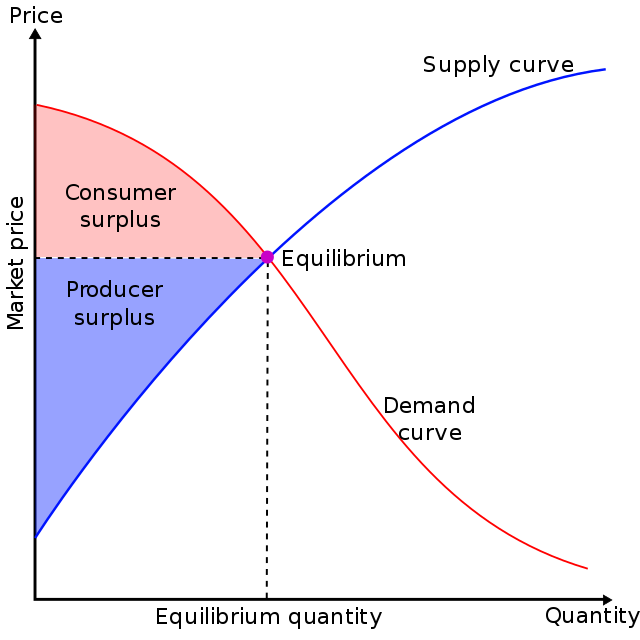

If we go back to our case, e.g., consumer surplus will be the following area:
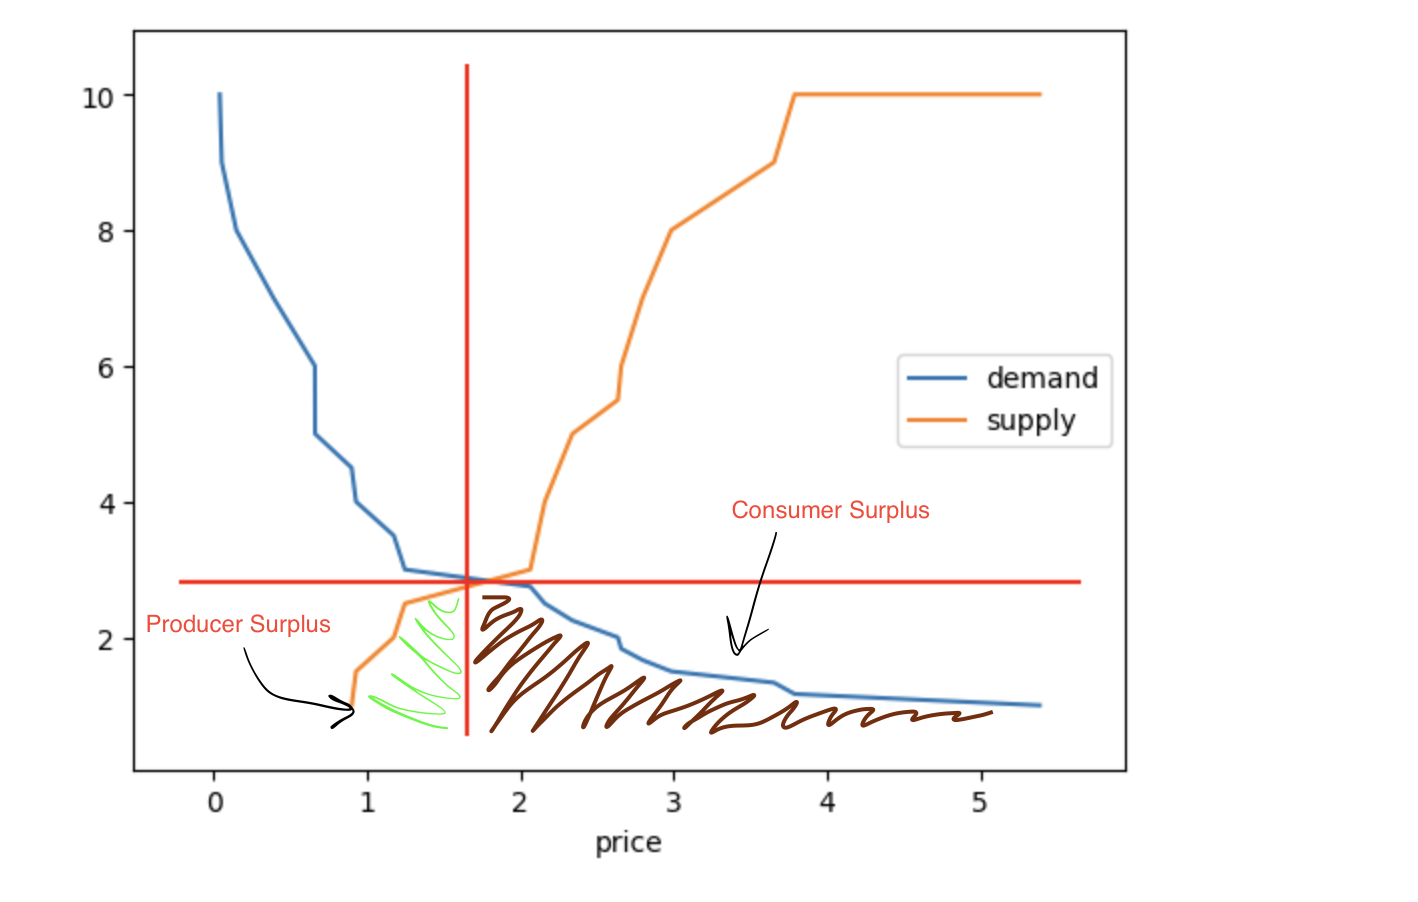

## Consumer surplus

In [ ]:
# The calculations in this case will be the following.
cons_surplus = supply_demand.copy()
# Isolate the consumer surplus part.
cons_surplus = cons_surplus[cons_surplus.index > eq_price]["demand"]
cons_surplus = cons_surplus.reset_index().set_index("demand")
cons_surplus = cons_surplus.sort_index()
cons_surplus = cons_surplus[cons_surplus.index.notnull()]
# cons_surplus.plot()

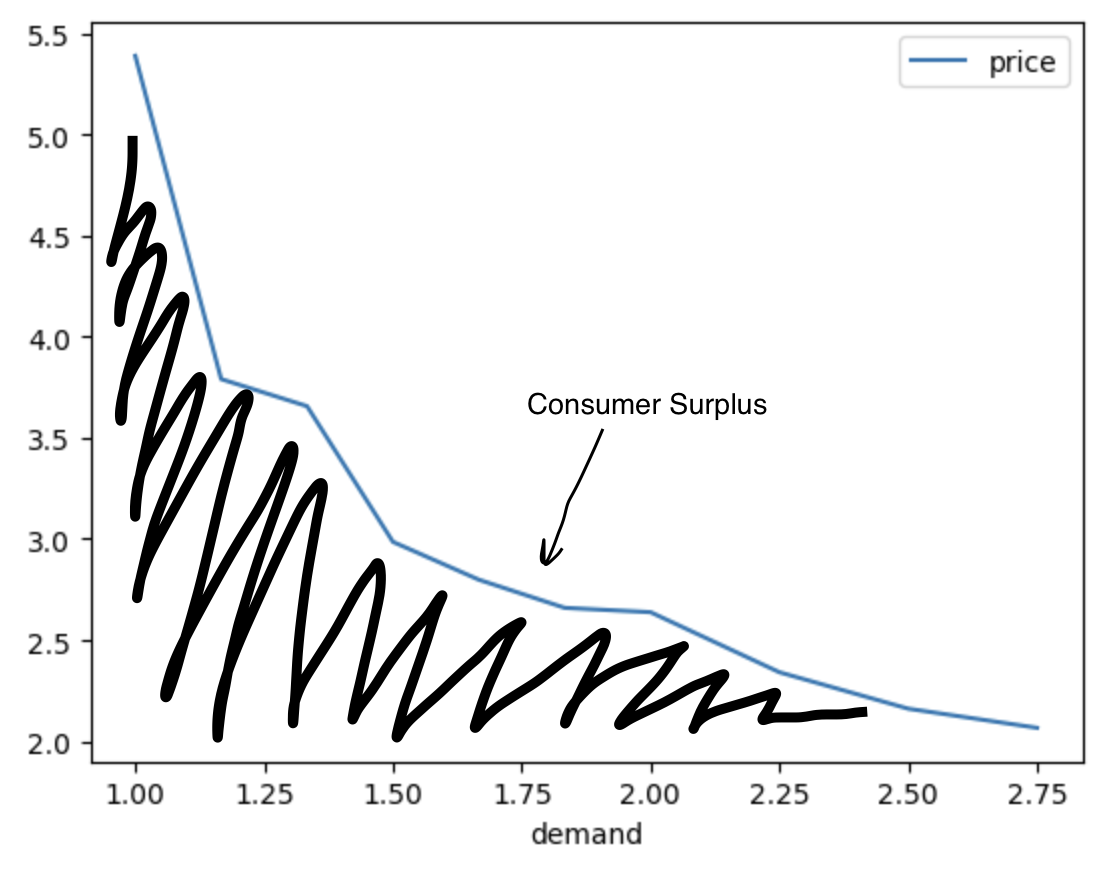

In [ ]:
# The area below the line equals to consumer surplus.
cons_surplus_value = np.trapz(y=cons_surplus["price"], x=cons_surplus.index)
square_cons = (cons_surplus.index.max() - cons_surplus.index.min()) * eq_price
cons_surplus_value -= square_cons
cons_surplus_value

## Producer surplus

In [ ]:
# The same but with producer surplus.
prod_surplus = supply_demand.copy()
# Isolate the producer surplus part.
prod_surplus = prod_surplus[prod_surplus.index < eq_price]["supply"]
prod_surplus = prod_surplus.reset_index().set_index("supply")
prod_surplus = prod_surplus.sort_index()
prod_surplus = prod_surplus[prod_surplus.index.notnull()]
# prod_surplus.plot()

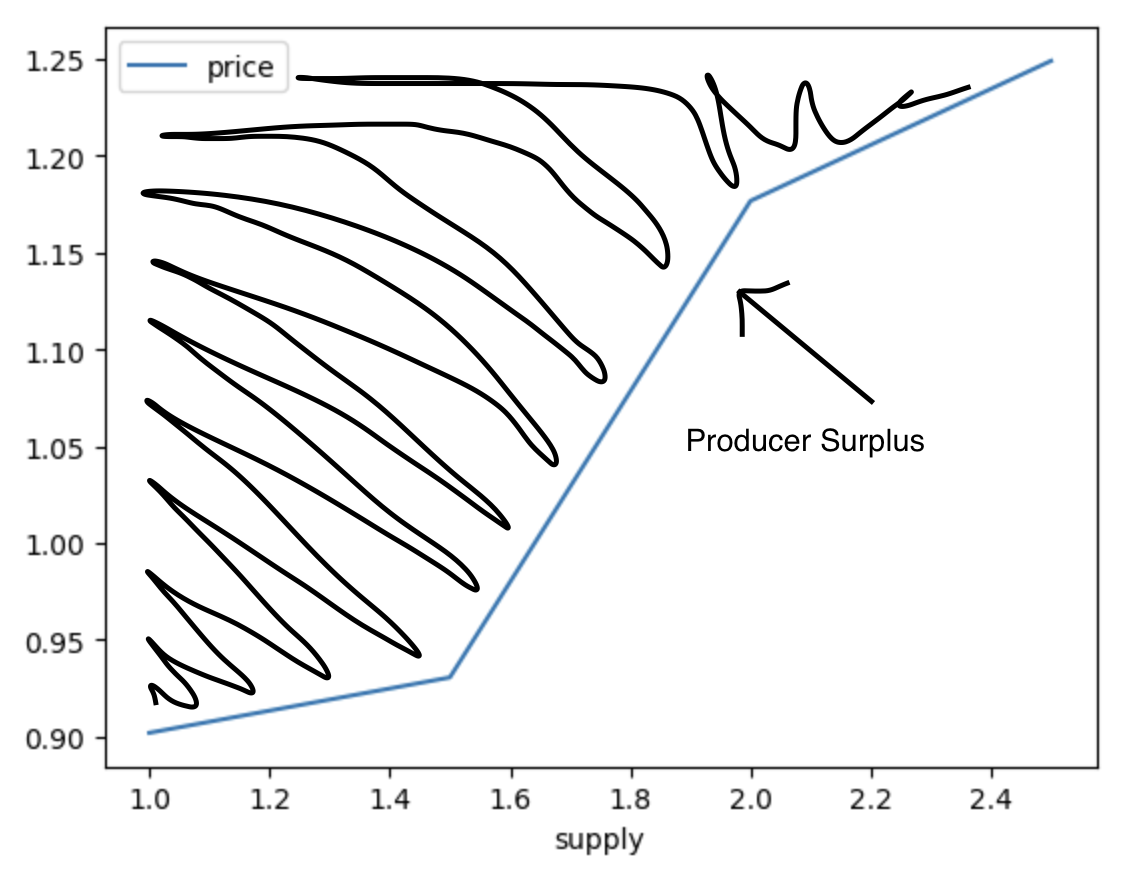

In [ ]:
# The area above the line is producer surplus.
# In this case we first need to find the square of the rectangle
# and subtract the square below the line.
ps_i = prod_surplus.index
ps_pr = prod_surplus["price"]
square_prod = (ps_i.max() - ps_i.min()) * ps_pr.max()
down_square_prod = np.trapz(y=ps_pr, x=ps_i)
prod_surplus_value = square_prod - down_square_prod
prod_surplus_value

## Total surplus

In [ ]:
total_surplus = prod_surplus_value + cons_surplus_value
total_surplus

# PDF of economic surplus

In [ ]:
# Create messy function for calculating economic surplus.
def calculate_economic_surplus(df, eq_price):
    # Consumer surplus.
    cons_surplus = df.copy()
    cons_surplus = cons_surplus[cons_surplus.index > eq_price]["demand"]
    cons_surplus = cons_surplus.reset_index().set_index("demand")
    cons_surplus = cons_surplus.sort_index()
    cons_surplus = cons_surplus[cons_surplus.index.notnull()]
    cons_surplus_value = np.trapz(y=cons_surplus["price"], x=cons_surplus.index)
    square_cons = (cons_surplus.index.max() - cons_surplus.index.min()) * eq_price
    cons_surplus_value -= square_cons
    # Producer surplus.
    prod_surplus = df.copy()
    prod_surplus = prod_surplus[prod_surplus.index < eq_price]["supply"]
    prod_surplus = prod_surplus.reset_index().set_index("supply")
    prod_surplus = prod_surplus.sort_index()
    prod_surplus = prod_surplus[prod_surplus.index.notnull()]
    ps_i = prod_surplus.index
    ps_pr = prod_surplus["price"]
    square_prod = (ps_i.max() - ps_i.min()) * ps_pr.max()
    down_square_prod = np.trapz(y=ps_pr, x=ps_i)
    prod_surplus_value = square_prod - down_square_prod
    #
    total_surplus = prod_surplus_value + cons_surplus_value
    return total_surplus

In [ ]:
# Check if the fucntion is true.
calculate_economic_surplus(supply_demand, eq_price) == total_surplus

In [ ]:
# MC simulation for obtaining economic surplus.
ec_surplus_df = pd.DataFrame()
for i in range(1, 500):
    ba_raw = ralololi.get_data(n_samples)
    sd = ralololi.get_supply_demand_curve(ba_raw)
    eq_p, _ = ralololi.find_equilibrium(sd, print_graph=False)
    total_surplus = calculate_economic_surplus(sd, eq_p)
    ec_surplus_df.loc[i, "econ_surplus"] = total_surplus

In [ ]:
ec_surplus_df.hist(bins=20)

## Distribution of economic surplus depending on N

In [ ]:
# MC simulation for obtaining economic surplus with random N.
ec_surplus_df_N = pd.DataFrame()
for i in range(1, 1000):
    N = random.choice(range(5, 1000))
    ba_raw = ralololi.get_data(N)
    sd = ralololi.get_supply_demand_curve(ba_raw)
    eq_p, _ = ralololi.find_equilibrium(sd, print_graph=False)
    total_surplus = calculate_economic_surplus(sd, eq_p)
    ec_surplus_df_N.loc[i, "N"] = N
    ec_surplus_df_N.loc[i, "econ_surplus"] = total_surplus

In [ ]:
ec_surplus_df_N["econ_surplus"].hist(bins=20)

More of a uniform distribution.

In [ ]:
ec_surplus_df_N.set_index("N").sort_index().plot()

Strong dependence of economic surplus with respect to N.

# Compare economic surplus of "big" and "small" markets

In [ ]:
def generate_three_numbers_with_given_sum(
    final_sum: int, threshold: int = 10
) -> list:
    """
    Randomly generate three numbers which sum will equal to the given number.
    """
    numbers = sorted(random.sample(range(final_sum), 2))
    num1 = numbers[0]
    num2 = numbers[1] - numbers[0]
    num3 = final_sum - numbers[1]
    final_list = [num1, num2, num3]
    for x in final_list:
        if x < threshold:
            final_list = generate_three_numbers_with_given_sum(final_sum)
    return final_list


def simulate_economic_surplus(N: int):
    ba_raw = ralololi.get_data(N)
    sd = ralololi.get_supply_demand_curve(ba_raw)
    eq_p, eq_q = ralololi.find_equilibrium(sd, print_graph=False)
    total_surplus = calculate_economic_surplus(sd, eq_p)
    return total_surplus, eq_p, eq_q

In [ ]:
# MC simulation for comparing economic surplus between "big" and "small" markets.
ec_surplus_df_N_markets = pd.DataFrame()
for i in range(1, 1000):
    # Generate the number of participants in a "big" market.
    N = random.choice(range(100, 500))
    # Simulate economic surplus for a "big" market.
    total_surplus_big, eq_p_big, eq_q_big = simulate_economic_surplus(N)
    ec_surplus_df_N_markets.loc[i, "N_big"] = N
    ec_surplus_df_N_markets.loc[i, "eq_p_big"] = eq_p_big
    ec_surplus_df_N_markets.loc[i, "eq_q_big"] = eq_q_big
    ec_surplus_df_N_markets.loc[i, "econ_surplus_big"] = total_surplus_big

    # Generate the number of participants in a three "small" markets.
    N_small = generate_three_numbers_with_given_sum(N)
    n1 = N_small[0]
    n2 = N_small[1]
    n3 = N_small[2]
    #
    total_surplus1, eq_p1, eq_q1 = simulate_economic_surplus(n1)
    ec_surplus_df_N_markets.loc[i, "n1"] = n1
    ec_surplus_df_N_markets.loc[i, "eq_p1"] = eq_p1
    ec_surplus_df_N_markets.loc[i, "eq_q1"] = eq_q1
    ec_surplus_df_N_markets.loc[i, "econ_surplus1"] = total_surplus1
    #
    total_surplus2, eq_p2, eq_q2 = simulate_economic_surplus(n2)
    ec_surplus_df_N_markets.loc[i, "n2"] = n2
    ec_surplus_df_N_markets.loc[i, "eq_p2"] = eq_p2
    ec_surplus_df_N_markets.loc[i, "eq_q2"] = eq_q2
    ec_surplus_df_N_markets.loc[i, "econ_surplus2"] = total_surplus2
    #
    total_surplus3, eq_p3, eq_q3 = simulate_economic_surplus(n3)
    ec_surplus_df_N_markets.loc[i, "n3"] = n3
    ec_surplus_df_N_markets.loc[i, "eq_p3"] = eq_p3
    ec_surplus_df_N_markets.loc[i, "eq_q3"] = eq_q3
    ec_surplus_df_N_markets.loc[i, "econ_surplus3"] = total_surplus3
    #
    ec_surplus_df_N_markets.loc[i, "econ_surplus_small_total"] = (
        total_surplus1 + total_surplus2 + total_surplus3
    )

In [ ]:
big_small_surpluses = (
    ec_surplus_df_N_markets[
        ["N_big", "econ_surplus_big", "econ_surplus_small_total"]
    ]
    .set_index("N_big")
    .sort_index()
)
big_small_surpluses.plot()

In [ ]:
big_small_diff = (
    big_small_surpluses["econ_surplus_big"]
    - big_small_surpluses["econ_surplus_small_total"]
)
print(f"Mean value of difference: {big_small_diff.mean()}")
big_small_diff.plot()

# Generate new demand and supply curves functions

## General function

In [ ]:
def generate_supply_demand_curve(curve_mode: str, mode: str, params: dict):
    """
    The output looks the following:
    ```
                  price
    quantity

    50.000000 10.000000
    49.322034 11.525424
    ...
    10.677966 98.474576
    10.000000 100.000000
    ```
    """
    if curve_mode == "linear":
        # Compute a linear curve between params["min_q"], params["min_price"]
        # and params["max_q"], params["max_price"] with params["n_agents"].
        prices = pd.Series(
            np.linspace(
                params["min_price"],
                params["max_price"],
                num=params["n_agents"],
            )
        )
        if mode == "demand":
            param_min = params["max_q"]
            param_max = params["min_q"]
        elif mode == "supply":
            param_min = params["min_q"]
            param_max = params["max_q"]
        quantities = pd.Series(
            np.linspace(
                param_min,
                param_max,
                num=params["n_agents"],
            )
        )
        # Combine prices and quantities together.
        df = pd.concat([prices, quantities], axis=1)
        df.columns = ["price", "quantity"]
        df = df.set_index("quantity")
        return df

In [ ]:
curve_mode = "linear"
supply_mode = "supply"
demand_mode = "demand"
params = {
    "min_q": 10,
    "min_price": 10,
    "max_q": 50,
    "max_price": 100,
    "n_agents": 60,
}
demand = generate_supply_demand_curve(curve_mode, demand_mode, params)
supply = generate_supply_demand_curve(curve_mode, supply_mode, params)
# Combine supply and demand curves.
market = pd.concat([demand, supply], axis=1)
market.columns = ["demand", "supply"]
market.plot()

## Generate buyers' distribution

In [ ]:
# Step 1.
def randomize_agents_on_prices(prices: int, n_agents: int) -> list:
    """
    Allocate n_agents on the available prices ensuring that there is at least one for each price.
    E.g.,:
    If there are 3 price groups (e.g., prices are [1,5,10]) and `n_agents` was set as 5,
    the possible outcome may be: [2,2,1]
    It can be interpreted as:
    - for price=1 -> 2 buyers
    - for price=5 -> 2 buyers
    - for price=10 -> 1 buyer

    :param prices: number of price points in supply/demand curve.
    :param n_agents: how many agents are operating in the market
    :return: number of agent for each of price groups
    """
    # Set the constraint that it should be at least one buyer in each group.
    n_agents_in_groups = [1] * prices
    # Allocate the remaining agents.
    remaining_agents = n_agents - prices
    # Probability of allocation.
    p = [1 / prices] * prices
    remaining_n_agents_in_groups = np.random.multinomial(remaining_agents, p)
    # Combine the initial agents (constrains) and the remaining ones.
    n_agents_in_groups = n_agents_in_groups + remaining_n_agents_in_groups
    return n_agents_in_groups


# Step 2.
def allocate_agents_on_quantities(
    n_agents_in_groups: list, quantities: list
) -> dict:
    """
    Calculate the indidual quantity distribution for each of supply or demand quantity.

    :param n_agents_in_groups: see `return` in `randomize_agents_on_prices()`
    :param quantities: quantity points in supply/demand curve
    :return: dict[supply quantity] = individual agents' quantities
    """
    agents_dict = {}
    for i in range(len(n_agents_in_groups)):
        if i == 0:
            # For the first quantity group the sum of individual quantities is
            # the whole quantity value from supply curve.
            quantity_in_group = quantities[i]
        else:
            # For the n+1 quantity group the sum of individual quantities is
            # the diff between neighbour quantity values from supply curve.
            quantity_in_group = quantities[i] - quantities[i - 1]
        # Allocate quantities for prices.
        ith_group = np.random.dirichlet(np.ones(n_agents_in_groups[i])) * (
            quantity_in_group
        )
        agents_dict[quantities[i]] = list(ith_group)
    return agents_dict


# General function.
def get_buyers_from_supply_curve(
    supply_curve: pd.DataFrame, num_buyers: int
) -> dict:
    """
    Compute the quantities for num_buyers that yields the given supply curve.

    :param supply_curve: supply data
    :param num_buyers: see `n_agents` param in `randomize_agents_on_prices()`
    :return: see `return` param in `allocate_agents_on_quantities()`
    """
    quantities = list(supply_curve.index)
    prices = len(quantities)
    # Generate random number of agents for each of price groups.
    n_agents_in_groups = randomize_agents_on_prices(prices, num_buyers)
    # For debugging.
    print(f"Number of Agents in groups:", n_agents_in_groups)
    # Calculate the indidual agents' quantity distribution for each of supply quantity.
    buyers_distribution = allocate_agents_on_quantities(
        n_agents_in_groups, quantities
    )
    return buyers_distribution

In [ ]:
mode = "linear"
params = {
    "min_q": 1,
    "min_price": 7,
    "max_q": 10,
    "max_price": 20,
    "n_agents": 10,
}

supply = generate_supply_curve(mode, params)
supply

In [ ]:
buyers = get_buyers_from_supply_curve(supply, 40)
buyers

In [ ]:
# Quick check: the whole sum of quantities from individual agents
# should be equal to the max quantity of supply curve.
supply.index.max() == sum([sum(buyers[key]) for key in buyers.keys()])